<a href="https://colab.research.google.com/github/Wasimds/MLOps_Training/blob/main/MLOps_Evidently_MLFlow_Final_Bicycle_Demand_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bike Rental Prediction and MLOps Demo**

### **Dataset Details**

The data set under study is related to 2-year Hourly usage log of a bike
sharing system namely Captial Bike Sharing (CBS) at Washington, D.C., USA. There are several reasons for this
data set to be a good fit for learning goals. **Firstly**, it includes at least
two full years of data and seems to be quite 
suitable for supervised and semi-supervised learning. **Secondly**, datasets contains external factors (ofcourse historical) corresponding environmental values such as weather conditions, weekdays and official holidays of Washington D.C. 
Please refer below section for detailed data dictionary. 



1.   dteday    : date of observation
2.   instance  : record index
3.   season    : season (1:Spring, 2:Summer, 3:Fall, 4:Winter)
4.   yr 		  : year of observation (0: 2011, 1:2012)
5.   mnth	  : 1 = January, ...., 12 = December
6.   hr 		  : hour (0 to 23)
7.   holiday   : whether the day was a holiday (1 = Yes, 0 = No)
8.   weekday	  : 0 = Sunday, .., 6 = Saturday
9.   workingday: whether the day was a work day (i.e., not a weekend or holiday) (1 = Yes; 0 = No)
10.   weathersit: type of weather
*   1 = clear, few clouds, partly cloudy
*   2 = mist & cloudy, mist & broken clouds, mist & few clouds, mist
*   3 = light snow, light rain & Thunderstorm & scattered clouds, light rain & scattered clouds
*   4 = heavy rain & ice pellets & thunderstorm & mist, snow & fog
11.   temp	  : Normalized temperature in Celsius. The values are divided to 41 (max)
12.   tempfeel  : Normalized feeling temperature in Celsius. The values are divided to 50 (max)
13.   hum		  : relative humidity in percent
14.   windspeed : windspeed in km/hour
15.   casual    : number of casual bike users
16.   registered: number of registered bike users
17.   cnt       : count of total rental bikes including both casual and registered

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving Bike_Rental_Data_Dictionary.jpg to Bike_Rental_Data_Dictionary (1).jpg
User uploaded file "Bike_Rental_Data_Dictionary.jpg" with length 161771 bytes


In [ ]:
import cv2
img = cv2.imread("/content/Bike_Rental_Data_Dictionary.jpg.jpg")
cv2.imshow(img)

In [ ]:
!pip install evidently
# !pip uninstall mlflow
# !pip install pyngrok --quiet

In [ ]:
!pip install mlflow

In [ ]:
!pip install pyngrok --quiet

In [5]:
import json
import pandas as pd
import numpy as np
import requests
import zipfile
import io

from datetime import datetime
from sklearn import datasets, ensemble

from evidently.dashboard import Dashboard
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.tabs import DataDriftTab, NumTargetDriftTab, RegressionPerformanceTab

import seaborn as sns
import matplotlib.pyplot as plt

from evidently.model_profile import Profile
from evidently.profile_sections import (DataDriftProfileSection,RegressionPerformanceProfileSection)
from evidently.pipeline.column_mapping import ColumnMapping

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## **Reading Hourly Bike Rental Data**

In [6]:
content = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip").content
with zipfile.ZipFile(io.BytesIO(content)) as arc:
    raw_data = pd.read_csv(arc.open("hour.csv"), header=0, sep=',', parse_dates=['dteday'], index_col='dteday')

## **Data Exploration**

In [51]:
print("Shape of the data",raw_data.shape)
print('#'* 100)
print("List of columns from in the data",raw_data.columns)  #list(raw_data.columns)
print('#'* 100)
print("Rawdata Information",raw_data.info())

Shape of the data (17379, 16)
####################################################################################################
List of columns from in the data Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
####################################################################################################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int6

In [9]:
raw_data.head(100)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-05,96,1,0,1,4,0,3,1,1,0.24,0.2273,0.48,0.2239,0,2,2
2011-01-05,97,1,0,1,5,0,3,1,1,0.22,0.2273,0.47,0.1642,0,3,3
2011-01-05,98,1,0,1,6,0,3,1,1,0.20,0.1970,0.47,0.2239,0,33,33


In [10]:
raw_data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Checking if there are any null values

In [11]:
raw_data.isnull().sum()

instant       0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

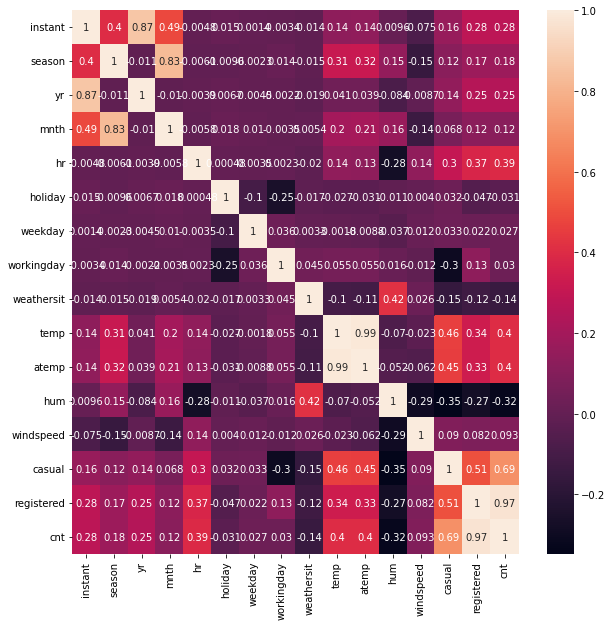

In [7]:
plt.figure(figsize = (10,10))
sns.heatmap(raw_data.corr(), annot = True)
plt.show()

### **There is strong correlation between Month and Season from above heatmap.**

In [8]:
print("Record Count Summary By Each Season")
print(str(raw_data['season'].value_counts()).split('\n'))   #season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
print('#'* 80)
print("Record Count Summary By Each Day Of The Week")
print(str(raw_data['weekday'].value_counts()).split('\n'))  # 0 = Sunday, .., 6 = Saturday
print('#'* 80)
print("Record Count Summary By Each Month")
print(str(raw_data['mnth'].value_counts()).split('\n'))  # 0 = Sunday, .., 6 = Saturday

Record Count Summary By Each Season
['3    4496', '2    4409', '1    4242', '4    4232', 'Name: season, dtype: int64']
################################################################################
Record Count Summary By Each Day Of The Week
['6    2512', '0    2502', '5    2487', '1    2479', '3    2475', '4    2471', '2    2453', 'Name: weekday, dtype: int64']
################################################################################
Record Count Summary By Each Month
['7     1488', '5     1488', '12    1483', '8     1475', '3     1473', '10    1451', '6     1440', '11    1437', '9     1437', '4     1437', '1     1429', '2     1341', 'Name: mnth, dtype: int64']


### **Above summary clearly indicates a spike in bike rentals during Summer and Fall.**

In [ ]:
def bargraphs(columns):
    for col in columns:
      plt.figure(figsize=(8,6))
      sns.set_palette("RdBu")      
      sns.countplot(x=col, data= raw_data)
      plt.show
bargraphs(['season', 'mnth', 'weathersit'])



*   **As noted earlier, bike rentals are high during Summer and Fall seasons from the above graphs for season and month.**
*   **It is evident from the above graph that, bike rentals are higher when the weather situation is good.**



In [ ]:
def distributionplot(columns):
    for col in columns:
        plt.figure(figsize=(14,6))
        sns.distplot(x = raw_data[col]) # distribution
        plt.show
distributionplot(['casual', 'registered', 'cnt'])

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(x='weekday',y='cnt', data=raw_data)
plt.show()

### **As per the above graph, data is positively skewed in each day of the weeek. Lets explore the presence fo outliers in data.**

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(x='season', y='cnt', data=raw_data)
plt.xlabel("Seasons (1= spring,  2= summer,  3= fall,  4= winter)", fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(x='hr',y='cnt', data=raw_data) 
plt.show()

### **We can see that large number of people rent bikes during Morning and Evening hours.**

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(x='yr',y='cnt', data=raw_data) 
plt.xlabel("Year (0 = 2011,  1 = 2012)", fontsize=16)
plt.show()

In [17]:
(raw_data == 0).sum()

instant           0
season            0
yr             8645
mnth              0
hr              726
holiday       16879
weekday        2502
workingday     5514
weathersit        0
temp              0
atemp             2
hum              22
windspeed      2180
casual         1581
registered       24
cnt               0
dtype: int64

Lets fill rows of Windspeed column wherever it is currently Zero.

In [9]:
raw_data['windspeed'] = raw_data['windspeed'].replace(0,np.NaN)

In [10]:
(raw_data == 0).sum()

instant           0
season            0
yr             8645
mnth              0
hr              726
holiday       16879
weekday        2502
workingday     5514
weathersit        0
temp              0
atemp             2
hum              22
windspeed         0
casual         1581
registered       24
cnt               0
dtype: int64

In [11]:
raw_data['windspeed'].isnull().sum()

2180

Let's now fill NaN with interpolate. Interpolate is using fill NaN value for time series data.

In [12]:
raw_data['windspeed'].fillna(method='bfill',inplace=True)
raw_data['windspeed'] = raw_data['windspeed'].interpolate()

In [13]:
raw_data['windspeed'].isnull().sum()

0

# **ML Model Training and Prediction**

In [14]:
target = 'cnt'
prediction = 'prediction'
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday', 'weathersit']
categorical_features = ['season', 'holiday', 'workingday']

In [15]:
reference = raw_data.loc['2011-01-01 00:00:00':'2012-08-31 23:00:00'] # Training Model On 19 Months Of Data
current = raw_data.loc['2012-09-01 00:00:00':'2012-12-31 23:00:00']   # Vaidation Model on 3 Months of Data (Sep'12, Oct'12 and Nov'12)
# test = raw_data.loc['2012-12-01 00:00:00':'2012-12-31 23:00:00']   # Testing Model on Dec'12 Data

In [ ]:
print("Reference Data Info Print",reference.info())
print('#'* 100)
print("Current Data Info Print",current.info())

In [16]:
# regressor = ensemble.RandomForestRegressor(random_state = 0, n_estimators = 100, max_depth=5, max_features="log2" )
regressor = ensemble.RandomForestRegressor(random_state = 0, n_estimators = 50)
model = regressor.fit(reference[numerical_features + categorical_features], reference[target])

In [17]:
ref_prediction = model.predict(reference[numerical_features + categorical_features])
current_prediction = model.predict(current[numerical_features + categorical_features])
# test_prediction = model.predict(test[numerical_features + categorical_features])
reference['prediction'] = ref_prediction
current['prediction'] = current_prediction
# test['prediction'] = test_prediction

In [18]:
from google.colab import files
import pickle
# pickle.dump(model, open('RFRegressorModel.pkl','wb'))
pickle.dump(model, open('/content/drive/MyDrive/MLOps_Training/RFRegressorModel.pkl','wb'))
# files.download(f'/content/drive/MyDrive/MLOps_Training/RFRegressorModel.pkl')

In [ ]:
reference.head()

In [ ]:
current.head()

In [19]:
column_mapping = ColumnMapping()
column_mapping.target = target
column_mapping.prediction = prediction
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

In [ ]:
column_mapping

ColumnMapping(target='cnt', prediction='prediction', datetime='datetime', id=None, numerical_features=['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday'], categorical_features=['season', 'holiday', 'workingday'], target_names=None)

In [ ]:
type(column_mapping)

evidently.pipeline.column_mapping.ColumnMapping

# **Regression Model Performance Testing**

In [31]:
regression_perfomance_dashboard = Dashboard(tabs=[RegressionPerformanceTab()])
regression_perfomance_dashboard.calculate(reference, None, column_mapping=column_mapping)
regression_perfomance_dashboard.show()
# regression_perfomance_dashboard.save('/content/drive/My Drive//regression_performance_at_training.html')

# **Regression Model Performance Testing Between Train and Test Data**

In [32]:
regression_perfomance_dashboard = Dashboard(tabs=[RegressionPerformanceTab()])
regression_perfomance_dashboard.calculate(reference, current, column_mapping=column_mapping)
regression_perfomance_dashboard.show()
# regression_perfomance_dashboard.save('/content/drive/My Drive//regression_performance_train_vs_test.html')

# **Week 1 - DRIFT detection for data, target and prediction**

In [35]:
regression_perfomance_dashboard.calculate(reference,
                                          current.loc['2012-12-01 00:00:00':'2012-12-07 23:00:00'],
                                          column_mapping=column_mapping)
regression_perfomance_dashboard.show()
#regression_perfomance_dashboard.save('reports/regression_performance_after_week1.html')

In [36]:
target_drift_dashboard = Dashboard(tabs=[NumTargetDriftTab()])
target_drift_dashboard.calculate(reference, 
                                 current.loc['2012-12-01 00:00:00':'2012-12-07 23:00:00'],
                                 column_mapping=column_mapping)
target_drift_dashboard.show()
#target_drift_dashboard.save('reports/target_drift_after_week1.html')

In [38]:
column_mapping = ColumnMapping()
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

data_drift_dashboard = Dashboard(tabs=[DataDriftTab()])
data_drift_dashboard.calculate(reference, 
                               current.loc['2012-12-01 00:00:00':'2012-12-07 23:00:00'],
                               column_mapping=column_mapping)
data_drift_dashboard.show()
# data_drift_dashboard.save("reports/data_drift_dashboard_after_week1.html")

# **Loading pickle file and testing on new data and analysing model performance**

In [42]:
# Loading model to compare the results
loadedmodel = pickle.load(open('/content/drive/MyDrive/MLOps_Training/RFRegressorModel.pkl','rb'))

# prevmnthdata = raw_data.loc['2012-11-01 00:00:00':'2012-11-30 23:00:00']   # Testing Model on Dec'12 Data
test = raw_data.loc['2012-12-01 00:00:00':'2012-12-31 23:00:00']   # Testing Model on Dec'12 Data
test_prediction = loadedmodel.predict(test[numerical_features + categorical_features])
test['prediction'] = test_prediction

column_mapping = ColumnMapping()
column_mapping.target = target
column_mapping.prediction = prediction
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

regression_perfomance_dashboard = Dashboard(tabs=[RegressionPerformanceTab()])
regression_perfomance_dashboard.calculate(reference, test, column_mapping=column_mapping)
regression_perfomance_dashboard.show()

# **Evidently Integration With MLFlow**

https://github.com/evidentlyai/evidently/blob/main/evidently/tutorials/mlflow_integration.ipynb

In [20]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

import plotly.offline as py #working offline
import plotly.graph_objs as go

In [21]:
#set reference dates
reference_dates = ('2011-01-01 00:00:00','2011-01-28 23:00:00')

#set experiment batches dates
experiment_batches = [
    ('2011-01-01 00:00:00','2011-01-29 23:00:00'),
    ('2011-01-29 00:00:00','2011-02-07 23:00:00'),
    ('2011-02-07 00:00:00','2011-02-14 23:00:00'),
    ('2011-02-15 00:00:00','2011-02-21 23:00:00'),  
]

In [29]:
#set column mapping for Evidently Profile
target = 'cnt'
prediction = 'prediction'
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday', 'weathersit']
categorical_features = ['season', 'holiday', 'workingday']

#set column mapping for Evidently Profile
data_columns = ColumnMapping()
data_columns.target = target
data_columns.prediction = prediction
data_columns.numerical_features = numerical_features
data_columns.categorical_features = categorical_features

In [30]:
#evaluate data drift with Evidently Profile
def eval_drift(reference, production, column_mapping):
    data_drift_profile = Profile(sections=[DataDriftProfileSection()])
    data_drift_profile.calculate(reference, production, column_mapping=column_mapping)
    report = data_drift_profile.json()
    json_report = json.loads(report)
    drifts = []
    num_features = column_mapping.numerical_features if column_mapping.numerical_features else []
    cat_features = column_mapping.categorical_features if column_mapping.categorical_features else []
    for feature in column_mapping.numerical_features + column_mapping.categorical_features:
        drifts.append((feature, json_report['data_drift']['data']['metrics'][feature]['p_value']))
    return drifts

In [44]:
#evaluate data drift with Evidently Profile
def model_drift(reference, production, column_mapping):
    data_drift_profile = Profile(sections=[RegressionPerformanceProfileSection()])
    data_drift_profile.calculate(reference, production, column_mapping=column_mapping)
    report = data_drift_profile.json()
    json_report = json.loads(report)
    drifts = []
    num_features = column_mapping.numerical_features if column_mapping.numerical_features else []
    cat_features = column_mapping.categorical_features if column_mapping.categorical_features else []
    for feature in column_mapping.numerical_features + column_mapping.categorical_features:
        drifts.append((feature, json_report['num_target_drift']['data']['metrics'][feature]['p_value']))
    return drifts

In [ ]:
rawdata = raw_data.loc['2011-01-01 00:00:00':'2012-08-31 23:00:00'] 
rawdata['prediction'] = ref_prediction
rawdata.head()

In [32]:
#log into MLflow
client = MlflowClient()

#set experiment
mlflow.set_experiment('Data Drift Evaluation With Evidently')

#start new run
for date in experiment_batches:
    with mlflow.start_run() as run: #inside brackets run_name='test'
        
        # Log parameters
        mlflow.log_param("begin", date[0])
        mlflow.log_param("end", date[1])

        # Log metrics
        metrics = eval_drift(rawdata.loc[reference_dates[0]:reference_dates[1]], 
                             rawdata.loc[date[0]:date[1]], 
                             column_mapping=data_columns)
        print(metrics)
        for feature in metrics:
            mlflow.log_metric(feature[0], round(feature[1], 4))
        print(run.info)

[('temp', 1.0), ('atemp', 0.9999999988359357), ('hum', 0.9996677817727767), ('windspeed', 0.9999999994169597), ('hr', 1.0), ('weekday', 0.9214371968373181), ('weathersit', 1.0), ('season', 1.0), ('holiday', 1.0), ('workingday', 0.9926716659661657)]
<RunInfo: artifact_uri='file:///content/mlruns/1/a0949a4135e1454cb2d8a6d9b9c34dc3/artifacts', end_time=None, experiment_id='1', lifecycle_stage='active', run_id='a0949a4135e1454cb2d8a6d9b9c34dc3', run_uuid='a0949a4135e1454cb2d8a6d9b9c34dc3', start_time=1641728577442, status='RUNNING', user_id='root'>
[('temp', 7.029098509914178e-06), ('atemp', 2.1094237467877974e-14), ('hum', 2.220446049250313e-16), ('windspeed', 1.279412742416497e-08), ('hr', 0.9999950814260455), ('weekday', 0.05445577176978533), ('weathersit', 0.055343014846846006), ('season', 1.0), ('holiday', 0.9483221193319364), ('workingday', 0.6487481881463268)]
<RunInfo: artifact_uri='file:///content/mlruns/1/b3544b40de2442e28efbccb9d8a587f2/artifacts', end_time=None, experiment_id='

In [34]:
#run MLflow UI (it will be more convinient to run it directly from the terminal)
!mlflow ui

[2022-01-09 11:43:12 +0000] [447] [INFO] Starting gunicorn 20.1.0
[2022-01-09 11:43:12 +0000] [447] [INFO] Listening at: http://127.0.0.1:5000 (447)
[2022-01-09 11:43:12 +0000] [447] [INFO] Using worker: sync
[2022-01-09 11:43:12 +0000] [450] [INFO] Booting worker with pid: 450
[2022-01-09 11:43:14 +0000] [447] [INFO] Handling signal: int

Aborted!
[2022-01-09 11:43:14 +0000] [450] [INFO] Worker exiting (pid: 450)
[2022-01-09 11:43:14 +0000] [447] [INFO] Shutting down: Master


In [35]:
with mlflow.start_run(run_name="Evidently and MLflow - Data Drift Demo From Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "evidently-mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "22unZF1cg5sUIVx8Il335I0pLFx_3gzoz22PLKUtXPX3zx4A3"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url) 

MLflow Tracking UI: https://eddd-35-204-158-86.ngrok.io
